In [1]:
from collections import defaultdict
import numpy as np
import scipy
import scipy.sparse as sps
import math
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_svmlight_file
import random
%matplotlib inline

# Support Vector Machines
## Classification Using SVM
Load dataset. We will use w1a dataset from LibSVM datasets https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/

The original optimization problem for the Support Vector Machine (SVM) is given by
\begin{equation}\label{eq:primal}
  \min_{w \in R^d} \  \sum_{i=1}^n \ell(y_i A_i^\top w) + \frac\lambda2 \|w\|^2
\end{equation}
where $\ell : R\rightarrow R$, $\ell(z) := \max\{0,1-z\}$ is the hinge loss function.
Here for any $i$, $1\le i\le n$, the vector $A_i\in R^d$ is the $i$-th data example, and $y_i\in\{\pm1\}$ is the corresponding label.
  
The dual optimization problem for the SVM is given by 
\begin{equation}\label{eq:dual}
 \max_{\boldsymbol{\alpha} \in R^n } \  \alpha^\top\boldsymbol{1} - \tfrac1{2\lambda} \alpha^\top Y A A^\top Y\alpha
 \text{    such that    $0\le \alpha_i \le 1  \ \forall i$}
\end{equation}
where $Y := \mathop{diag}(y)$, and $A\in R^{n \times d}$ again collects all $n$ data examples as its columns. 

Note that $w$ can be derived from $\alpha$ as
\begin{equation}
    w(\alpha) = \frac{1}{\lambda} A^\top Y \alpha.
\end{equation}

In [2]:
DATA_TRAIN_PATH = 'data/w1a'

A, y = load_svmlight_file(DATA_TRAIN_PATH)
A = A.toarray()
print(y.shape, A.shape)

(2477,) (2477, 300)


## Prepare cost and prediction functions

In [3]:
def calculate_primal_objective(y, A, w, lambda_):
    """
    Compute the full cost (the primal objective), that is loss plus regularizer.
    y: +1 or -1 labels, shape = (num_examples)
    A: Dataset matrix, shape = (num_examples, num_features)
    w: Model weights, shape = (num_features)
    return: scalar value
    """
    regularizer = lambda_ * np.linalg.norm(w, 2)**2
    loss = np.sum(np.maximum(1 - y * (A @ w), 0))
    return loss + regularizer

In [4]:
def calculate_accuracy(y, A, w):
    """
    Compute the training accuracy on the training set (can be called for test set as well).
    y: +1 or -1 labels, shape = (num_examples)
    A: Dataset matrix, shape = (num_examples, num_features)
    w: Model weights, shape = (num_features)
    return: scalar value
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # ***************************************************
    pred = np.sign(A @ w)
    pred[np.where(pred==0)[0]] = 1
    acc = np.sum(pred == y) / len(pred)
    return acc

## Coordinate Descent (Ascent) for SVM

Compute the closed-form update for the i-th variable alpha, in the dual optimization problem, given alpha and the current corresponding w.


Hints: 
- Differentiate the dual objective with respect to one `alpha[i]`.
- Set the derivative to zero to compute a new `alpha[i]`.
- Make sure the values of alpha stay inside a `[0, 1]` box.
- You can formulate the update as `alpha[i] = projection(alpha[i] + lambda_ * (some update))`.
- You can test the correctness of your implementation by checking if the difference between the dual objective and primal objective goes to zero. This difference, the duality gap, should get smaller than 10 in 700000 iterations.

In [139]:
def calculate_coordinate_update(y, A, lambda_, alpha, w, i):
    """
    Compute a coordinate update (closed form) for coordinate i.
    y: +1 or -1 labels, shape = (num_examples)
    A: Dataset matrix, shape = (num_examples, num_features)
    lambda_: Regularization parameter, scalar
    alpha: Dual variables, shape = (num_examples)
    w: Model weights, shape = (num_examples)
    i: Index of the entry of the dual variable 'alpha' that is to be updated
    return: New weights w (shape (num_features)), New dual variables alpha (shape (num_examples))
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # ***************************************************
    # calculate the update of coordinate at index=n.
    a_i, y_i = A[i], y[i]
    old_alpha_i = np.copy(alpha[i])
    
    idxs = np.append(np.arange(i), np.arange(i+1, len(y)))
    
    alpha[i] = (lambda_ - np.sum(((A[idxs].T * (y_i * y[idxs] * alpha[idxs]))).T @ a_i)) / np.linalg.norm(a_i)**2
    alpha[i] = np.maximum(np.minimum(alpha[i], 1), 0)
    
    w = w + a_i * ((y_i * (alpha[i] - old_alpha_i)) / lambda_)
    
    return w, alpha

In [14]:
def calculate_dual_objective(y, A, w, alpha, lambda_):
    """
    Calculate the objective for the dual problem.
    Follow the formula given above.
    y: +1 or -1 labels, shape = (num_examples)
    A: Dataset matrix, shape = (num_examples, num_features)
    alpha: Dual variables, shape = (num_examples)
    lambda_: Regularization parameter, scalar
    return: Scalar value
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # ***************************************************
    
    return np.sum(alpha) - (1 / (2*lambda_)) * np.sum((alpha * y) @ A @ A.T @ (y * alpha))

In [143]:
def coordinate_descent_for_svm_demo(y, A, trace=False):
    max_iter = 100000
    lambda_ = 0.01
    history = defaultdict(list) if trace else None
    
    num_examples, num_features = A.shape
    w = np.zeros(num_features)
    alpha = np.zeros(num_examples)

    for it in range(max_iter):
        # i = sample one data point uniformly at random from the columns of A
        i = random.randint(0,num_examples-1)
        
        w, alpha = calculate_coordinate_update(y, A, lambda_, alpha, w, i)
        
        if it % 1000 == 0:
            # primal objective
            primal_value = calculate_primal_objective(y, A, w, lambda_)
            # dual objective
            dual_value = calculate_dual_objective(y, A, w, alpha, lambda_)
            # primal dual gap
            duality_gap = primal_value - dual_value

            print('iteration=%i, primal:%.5f, dual:%.5f, gap:%.5f'%(
                    it, primal_value, dual_value, duality_gap))
        if it % 1000 == 0:
            primal_value = calculate_primal_objective(y, A, w, lambda_)
            if trace:
                history["objective_function"] += [primal_value]
                history['iter'].append(it)

            
    print("training accuracy = {l}".format(l=calculate_accuracy(y, A, w)))
    return history

history_cd = coordinate_descent_for_svm_demo(y, A, trace=True)


/tmp/ipykernel_16805/429604365.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  alpha[i] = (lambda_ - np.sum(((A[idxs].T * (y_i * y[idxs] * alpha[idxs]))).T @ a_i)) / np.linalg.norm(a_i)**2


iteration=0, primal:2477.00000, dual:1.00000, gap:2476.00000
iteration=1000, primal:423.93571, dual:78.27808, gap:345.65762
iteration=2000, primal:544.27900, dual:117.46075, gap:426.81825
iteration=3000, primal:452.47932, dual:144.65356, gap:307.82575
iteration=4000, primal:369.59819, dual:165.78682, gap:203.81137
iteration=5000, primal:359.19594, dual:180.87137, gap:178.32457
iteration=6000, primal:353.42006, dual:184.97332, gap:168.44674
iteration=7000, primal:349.03114, dual:193.11221, gap:155.91893
iteration=8000, primal:363.02717, dual:198.30214, gap:164.72503
iteration=9000, primal:346.53978, dual:201.44288, gap:145.09690
iteration=10000, primal:363.38976, dual:203.58812, gap:159.80164
iteration=11000, primal:358.73336, dual:205.77176, gap:152.96160
iteration=12000, primal:339.65175, dual:205.97470, gap:133.67705
iteration=13000, primal:321.16338, dual:207.08042, gap:114.08296
iteration=14000, primal:352.54205, dual:207.21749, gap:145.32456
iteration=15000, primal:387.51731, dual

# Stochastic gradient descent for SVM

Let's now compare it with SGD on original problem for the SVM. In this part, you will implement stochastic gradient descent on the primal SVM objective. The stochasticity comes from sampling data points.

In [8]:
def compute_stoch_gradient_svm(A_sample, b_sample, lambda_, w_t, num_data_points):
    """
    Calculate stochastic gradient over A_batch, b_batch.
    A_sample: A data sample, shape=(num_features)
    b_sample: Corresponding +1 or -1 label, scalar
    w_t: Model weights, shape=(num_features)
    num_data_points: Total size of the dataset, scalar integer
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # ***************************************************
    reg_grad = 2 * lambda_ * w_t
    if b_sample * A_sample @ w_t >= 1:
        loss_grad = np.zeros(len(w_t))
    else:
        loss_grad = -np.sum(b_sample * A_sample, axis=0)
    
    return loss_grad + reg_grad

In [144]:
def stochastic_gradient_descent_svm_demo(A, b, gamma, batch_size=1, trace=False):
    history = defaultdict(list) if trace else None
    num_data_points, num_features = np.shape(A)
    max_iter = 100000
    lambda_ = 0.01
    
    w_t = np.zeros(num_features)
    
    current_iter = 0
    while (current_iter < max_iter):
        i = random.randint(0,num_data_points - 1)
        b_batch, A_batch = b[i], A[i]
        gradient = compute_stoch_gradient_svm(A_batch, b_batch, lambda_, w_t, num_data_points)
        w_t = w_t - gamma * gradient
        if current_iter % 1000 == 0:
            primal_value = calculate_primal_objective(y, A, w_t, lambda_)
            print('iteration=%i, primal:%.5f'%(
                    current_iter, primal_value))
        if current_iter % 1000 == 0:
            primal_value = calculate_primal_objective(y, A, w_t, lambda_)
            if trace:
                history['objective_function'].append(primal_value)
                history['iter'].append(current_iter)
        current_iter += 1
    print("training accuracy = {l}".format(l=calculate_accuracy(y, A, w_t)))
    return history


Try different stepsized and find the best one

In [147]:
gamma = 0.0001
history_sgd = stochastic_gradient_descent_svm_demo(A, y, gamma, trace=True)


iteration=0, primal:2409.47502
iteration=1000, primal:687.78718
iteration=2000, primal:647.88887
iteration=3000, primal:640.63783
iteration=4000, primal:638.33083
iteration=5000, primal:634.61217
iteration=6000, primal:627.34359
iteration=7000, primal:626.78773
iteration=8000, primal:626.92595
iteration=9000, primal:626.91452
iteration=10000, primal:626.79755
iteration=11000, primal:626.90621
iteration=12000, primal:626.73647
iteration=13000, primal:628.71634
iteration=14000, primal:626.71954
iteration=15000, primal:626.74906
iteration=16000, primal:628.70986
iteration=17000, primal:626.93010
iteration=18000, primal:629.21386
iteration=19000, primal:626.72112
iteration=20000, primal:628.25431
iteration=21000, primal:626.79404
iteration=22000, primal:626.76429
iteration=23000, primal:626.75798
iteration=24000, primal:626.81990
iteration=25000, primal:626.93463
iteration=26000, primal:627.03084
iteration=27000, primal:626.84323
iteration=28000, primal:627.02520
iteration=29000, primal:62

Plot learning curves

Text(0.5, 1.0, 'CD vs SGD')

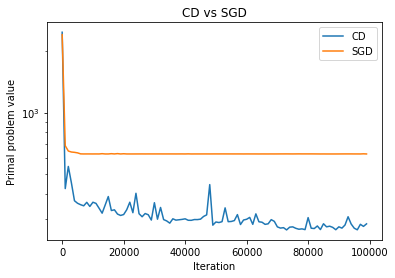

In [157]:
fig, ax = plt.subplots()
plt.plot(np.arange(len(history_cd['objective_function']))*1000, history_cd['objective_function'], label="CD")
plt.plot(np.arange(len(history_sgd['objective_function']))*1000, history_sgd['objective_function'], label="SGD")
plt.legend()
plt.ylabel("Primal problem value")
plt.xlabel("Iteration")
plt.yscale("log")
plt.title("CD vs SGD")

## Compare SGD with Coordinate Descent

Compare two algorithms in terms of convergence, time complexities per iteration. Which one is easier to use?